# Git 101

- What is Git? Why Git? (["FINAL".doc](Why Git? "FINAL".doc))
- Installation ([download](https://git-scm.com/downloads)).
- What is [GitHub](https://github.com/)? (and SourceForge, Bitbucket and GitLab).
- Create GitHub account. [Set-up](https://docs.github.com/en/authentication/connecting-to-github-with-ssh) SSH connection*.
- Clone a repository.
- The Basics (nice resources [here](https://gist.github.com/brandon1024/14b5f9fcfd982658d01811ee3045ff1e) and [here](https://harshkapadia2.github.io/git_basics/)).
- Create a new repository and push commits.
- Create a new branch and push a merge request.

# Week 3 Lab

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc as pm ## If this line gives you an error, uncomment and execute the following cell

Populating the interactive namespace from numpy and matplotlib


# We can (optionally) specify the random seed for our random number generators

In [3]:
RANDOM_SEED = 8927
random.seed(RANDOM_SEED)

# Load the dataset stored in a CSV (comma separated value) file
We use the Python package called Pandas to read the data from a CSV file and as a data structure to work with the data. The data structure is called a Data Frame.

In [5]:
path_to_data = 'https://raw.githubusercontent.com/ccontrer/MATH509-Winter2025-JupyterNotebooks/main/Data/'
data_all = pd.read_csv(path_to_data + "Howell1.csv", sep=";", header=0)
data_all

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


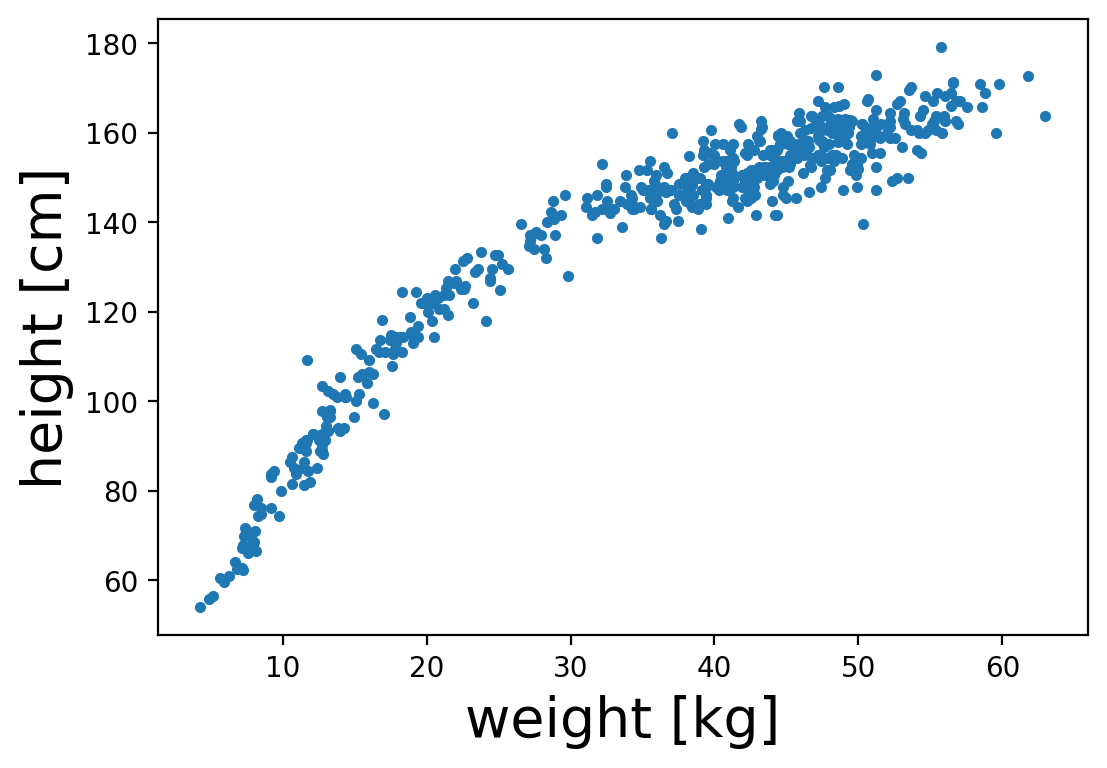

In [6]:
figure(1, [6, 4])
plot(data_all['weight'], data_all['height'], '.')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

## We want to filter for only those over age 18

In [7]:
data_adult = data_all[data_all['age'] >= 18] ## this is logical indexing (it also works for arrays)
data_adult

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0


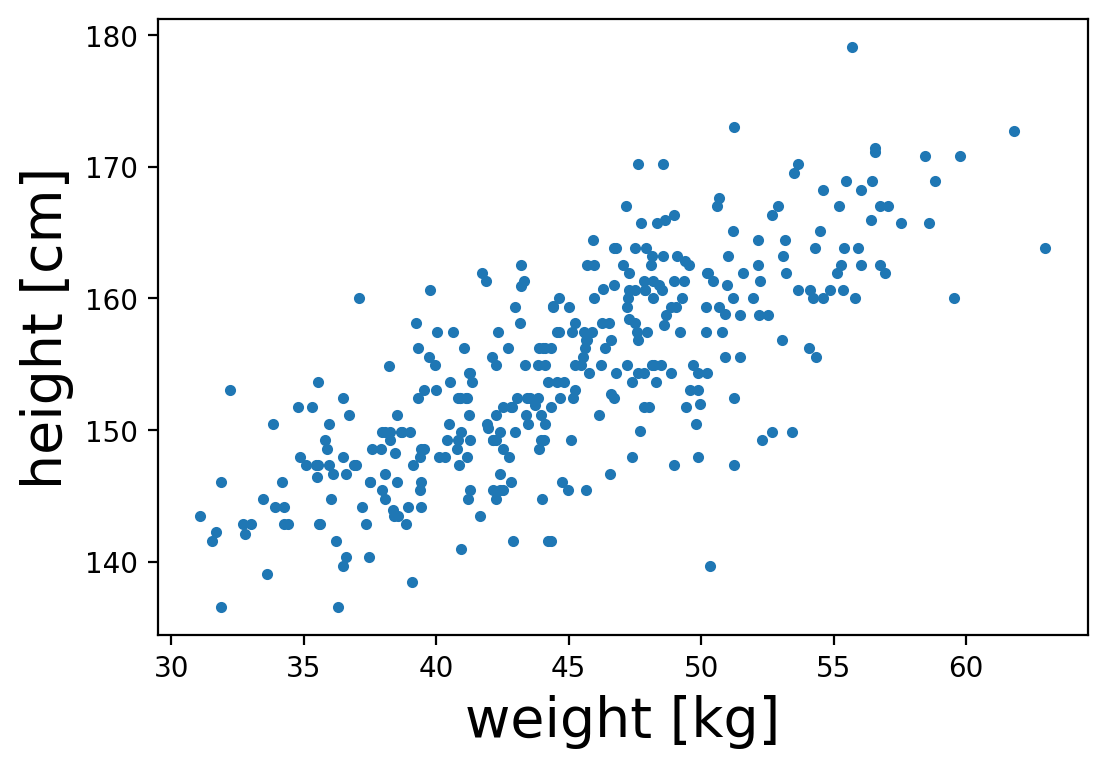

In [8]:
figure(1, [6, 4])
plot(data_adult['weight'], data_adult['height'], '.')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

# Statiscal model
\begin{align*}
    h_{i} &\sim \text{Normal}(\mu_{i}, \sigma) \\
    \mu_{i} &= \alpha + \beta(x_{i} - \bar{x}) \\
    \alpha &\sim \text{Normal}(178, 20) \\
    \beta & \sim \text{Normal}(0, 10) \\
    \sigma &\sim \text{Uniform}(0, 50)
  \end{align*}

## Let's check our prior to see if it makes sense

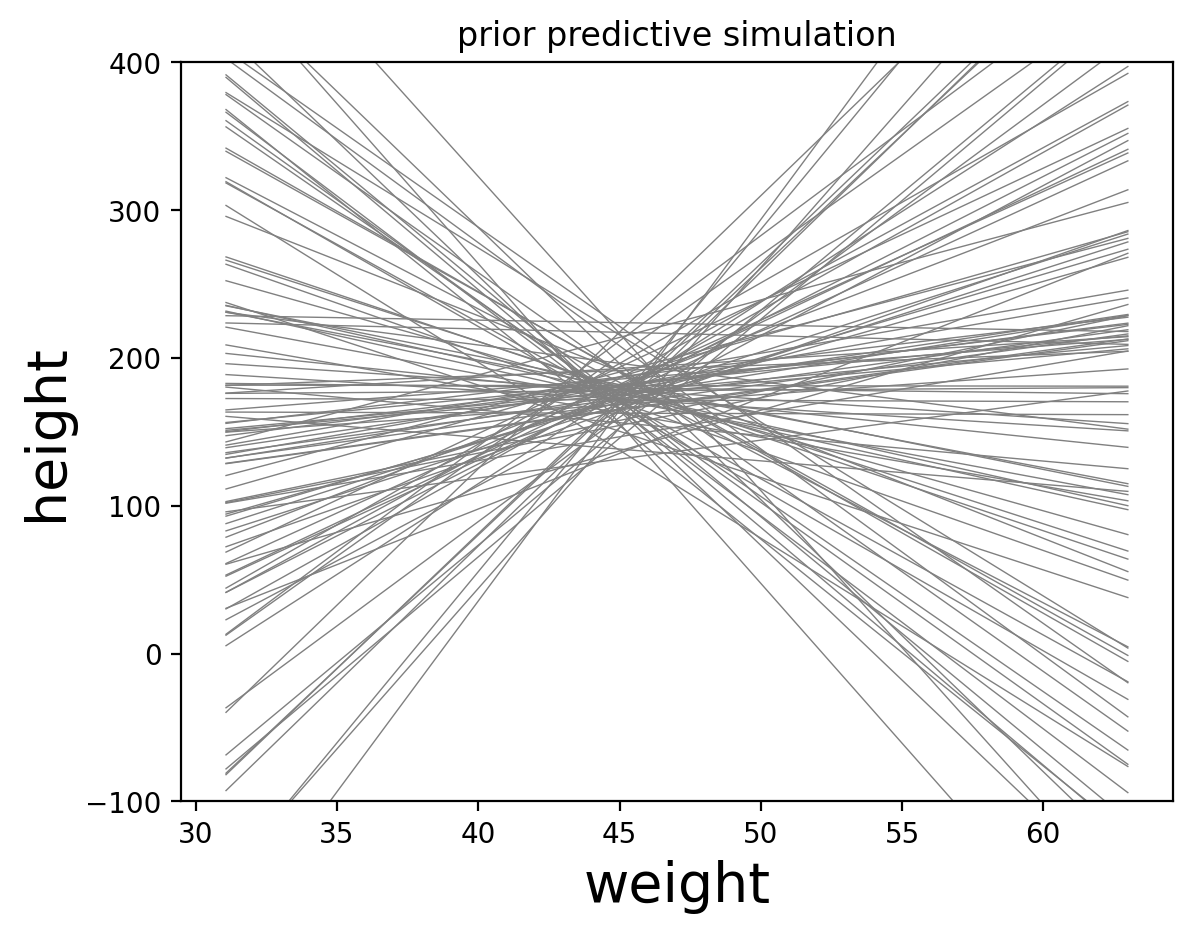

In [9]:
n_samples = 100  # 100 lines
alpha = stats.norm.rvs(178, 20, n_samples)
beta = stats.norm.rvs(0, 10, n_samples)

xmin = data_adult['weight'].min()
xmax = data_adult['weight'].max()
xmean = data_adult['weight'].mean()
x = linspace(xmin, xmax, 5) ## weight range

## we are using broadcasting here (see Notebook in Week 3)
h_avg = alpha[None, :] + beta[None, :]*(x[:, None] - xmean)

plot(x, h_avg, '0.5', lw=0.5)
ylim(-100, 400)
title('prior predictive simulation')
xlabel('weight', fontsize=20)
ylabel('height', fontsize=20);

## As suggested in the book, let us try a different prior for $\beta$

$$ \log(\beta) \sim \text{Normal}(0, 1) $$
or more usefully
$$ \beta \sim \text{Lognormal(0, 1)}$$


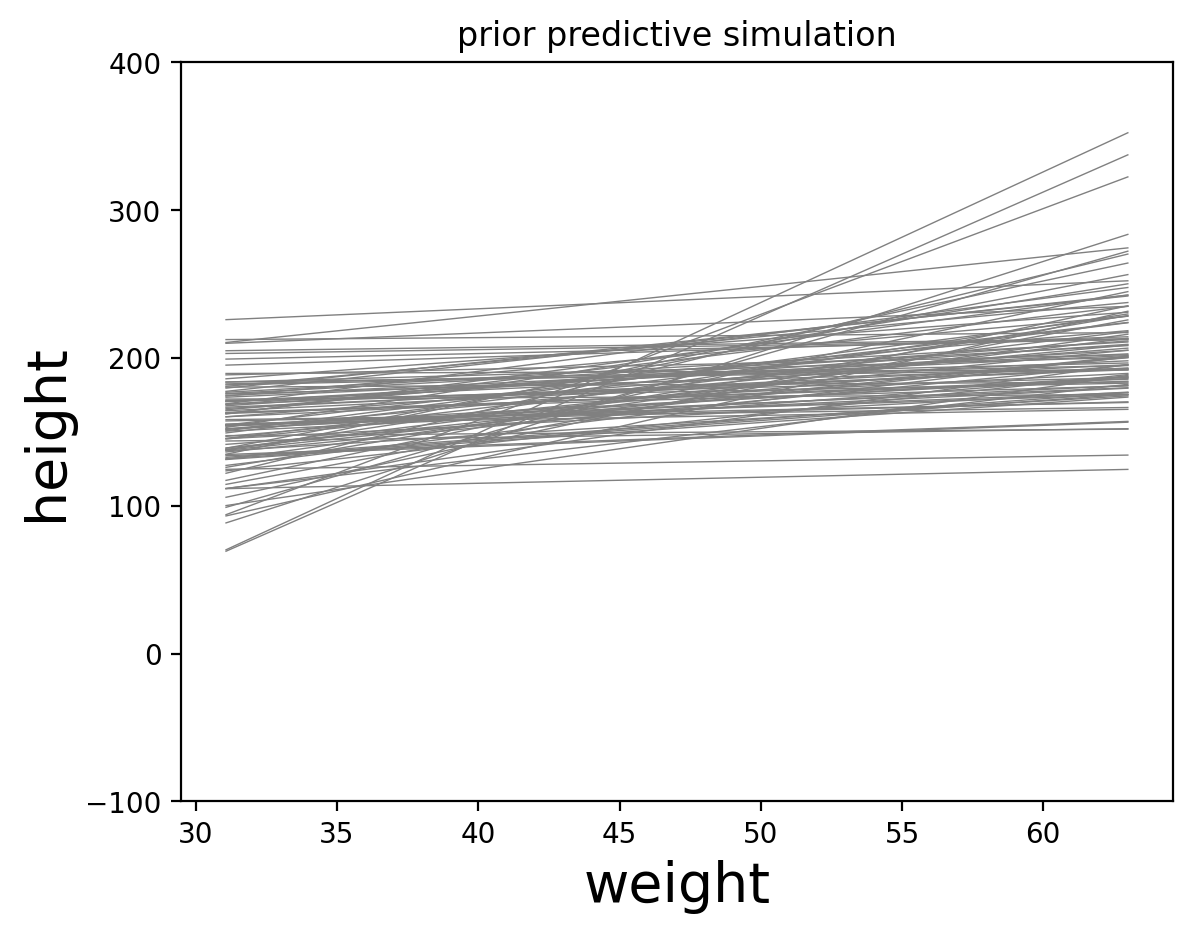

In [10]:
n_samples = 100  # 100 lines
alpha = stats.norm.rvs(178, 20, n_samples)
logbeta = stats.norm.rvs(0, 1, n_samples)

xmin = data_adult['weight'].min()
xmax = data_adult['weight'].max()
xmean = data_adult['weight'].mean()
x = linspace(xmin, xmax, 5) ## weight range
h_avg = alpha[None, :] + exp(logbeta[None, :])*(x[:, None] - xmean) ## we are using broadcasting here

plot(x, h_avg, '0.5', lw=0.5)
ylim(-100, 400)
title('prior predictive simulation')
xlabel('weight', fontsize=20)
ylabel('height', fontsize=20);

# Use the MCMC sampling tools in the PyMC3 package to approximate the posterior distribution
\begin{align*}
    h_{i} &\sim \text{Normal}(\mu_{i}, \sigma) \\
    \mu_{i} &= \alpha + e^{log(\beta)}(x_{i} - \bar{x}) \\
    \alpha &\sim \text{Normal}(178, 20) \\
    \log(\beta) & \sim \text{Normal}(0, 1) \\
    \sigma &\sim \text{Uniform}(0, 50)
  \end{align*}

In [ ]:
pm.Normal

In [11]:
with pm.Model() as model_4_3:
    sigma = pm.Uniform("sigma", 0, 50) ## uniform prior for sigma
    alpha = pm.Normal("alpha", mu=178, sigma=20) ## normal prior for alpha
    logbeta = pm.Normal("logbeta", mu=0, sigma=1) ## normal prior for logbeta
    mu = alpha + exp(logbeta)*(data_adult['weight'] - data_adult['weight'].mean()) ## linear model (hidden variable)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data_adult['height']) ## likelihood
    trace_4_3 = pm.sample(1000, tune=1000) ## these are the MCMC samples!

Output()

Output()

In [16]:
trace_4_3

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

## Convert the posterior sample output into a DataFrame
## Most of the rest of the notebook will use these MCMC samples!

In [17]:
trace_4_3_df = trace_4_3.posterior.to_dataframe()
trace_4_3_df

alpha   logbeta     sigma
chain draw                                
0     0     154.791481 -0.181864  4.980641
      1     154.493813 -0.089424  4.876968
      2     154.592048 -0.121067  4.877176
      3     154.452397 -0.134890  4.873404
      4     154.634745 -0.102887  5.305721
...                ...       ...       ...
1     995   154.664229 -0.120406  5.275665
      996   154.466834 -0.078077  4.905662
      997   154.840490 -0.167186  5.092597
      998   154.265514 -0.049548  5.105575
      999   154.701197 -0.131627  5.171261

[2000 rows x 3 columns]

# What is the posterior probability of the average height $\mu$ of someone whos weight is $50$kg
$$ p(\mu | w=50{\rm kg}, \text{data})= \alpha + e^{log(\beta)}(50 - \bar{x})$$

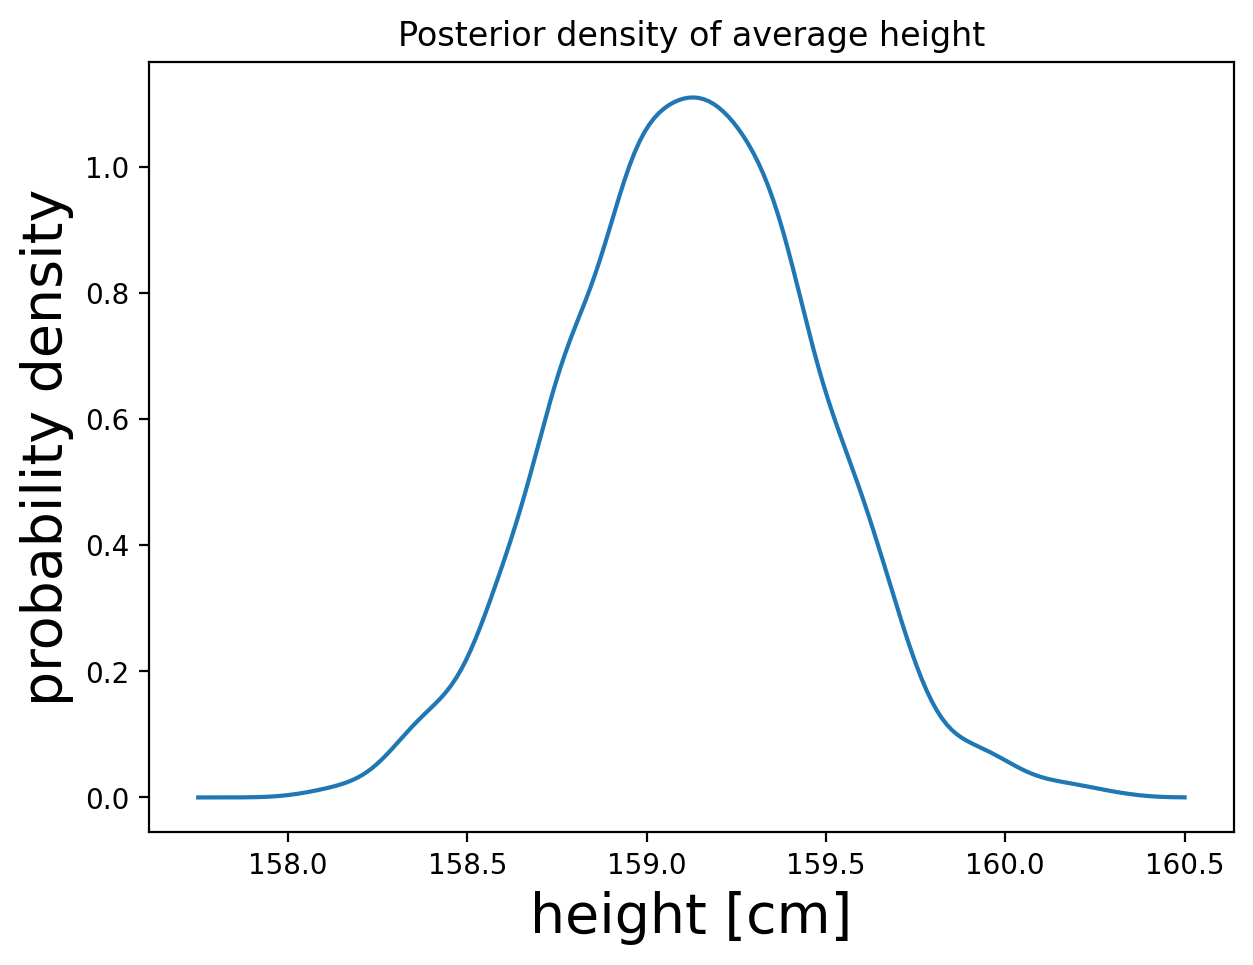

In [18]:
alpha_samples = array(trace_4_3_df['alpha'])
logbeta_samples = array(trace_4_3_df['logbeta'])
h_avg_samples = alpha_samples + exp(logbeta_samples)*(50 - data_adult['weight'].mean())

## using code from Week 3 notebook
kde_posterior_pdf = stats.gaussian_kde(h_avg_samples)
figure(1, [7, 5])
x_to_plot = linspace(157.75, 160.5, 200)
plot(x_to_plot, kde_posterior_pdf(x_to_plot))
title('Posterior density of average height')
xlabel('height [cm]', fontsize=20)
ylabel('probability density', fontsize=20);

## What about the posterior for the height $h$ (instead of the average height $\mu$)?
$$ p(h | w=50{\rm kg}, \text{data}) = \text{Normal}(\alpha + e^{log(\beta)}(50 - \bar{x}), \sigma)$$

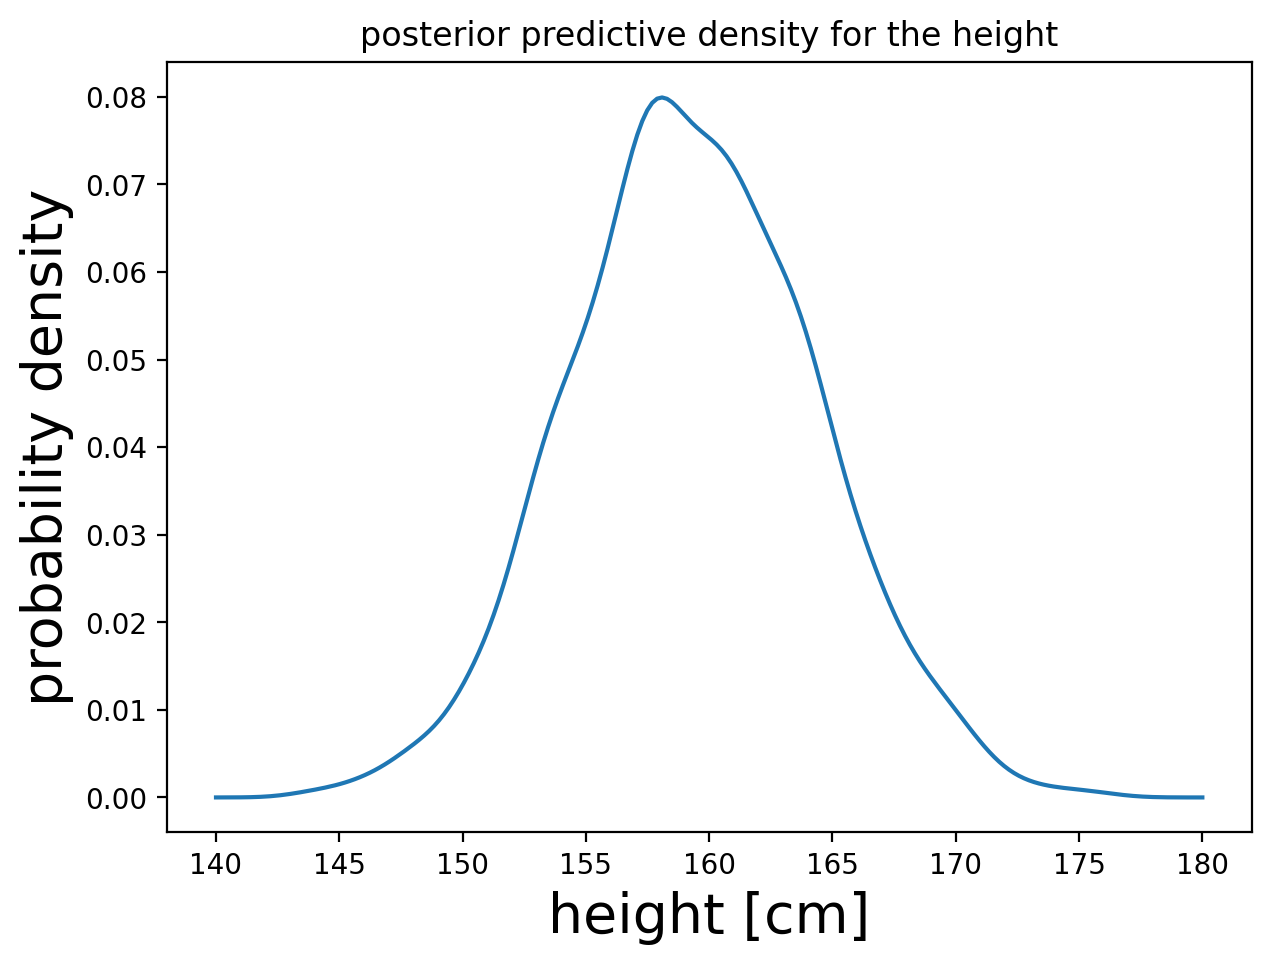

In [19]:
alpha_samples = array(trace_4_3_df['alpha'])
logbeta_samples = array(trace_4_3_df['logbeta'])
mu_samples = alpha_samples + exp(logbeta_samples)*(50 - data_adult['weight'].mean())
sigma_samples = array(trace_4_3_df['sigma'])


h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=sigma_samples.size)

## using code from Week 3 notebook
kde_posterior_pred_pdf = stats.gaussian_kde(h_samples)
figure(1, [7, 5])
# x_to_plot = linspace(157.75, 160.5, 200)
# plot(x_to_plot, kde_posterior_pdf(x_to_plot), label='Posterior pdf of avg height')
x_to_plot = linspace(140, 180, 200)
plot(x_to_plot, kde_posterior_pred_pdf(x_to_plot), label='Posterior pdf of height')
title('posterior predictive density for the height')
xlabel('height [cm]', fontsize=20)
ylabel('probability density', fontsize=20);

# Graphing the posterior distribution of average height $\mu$

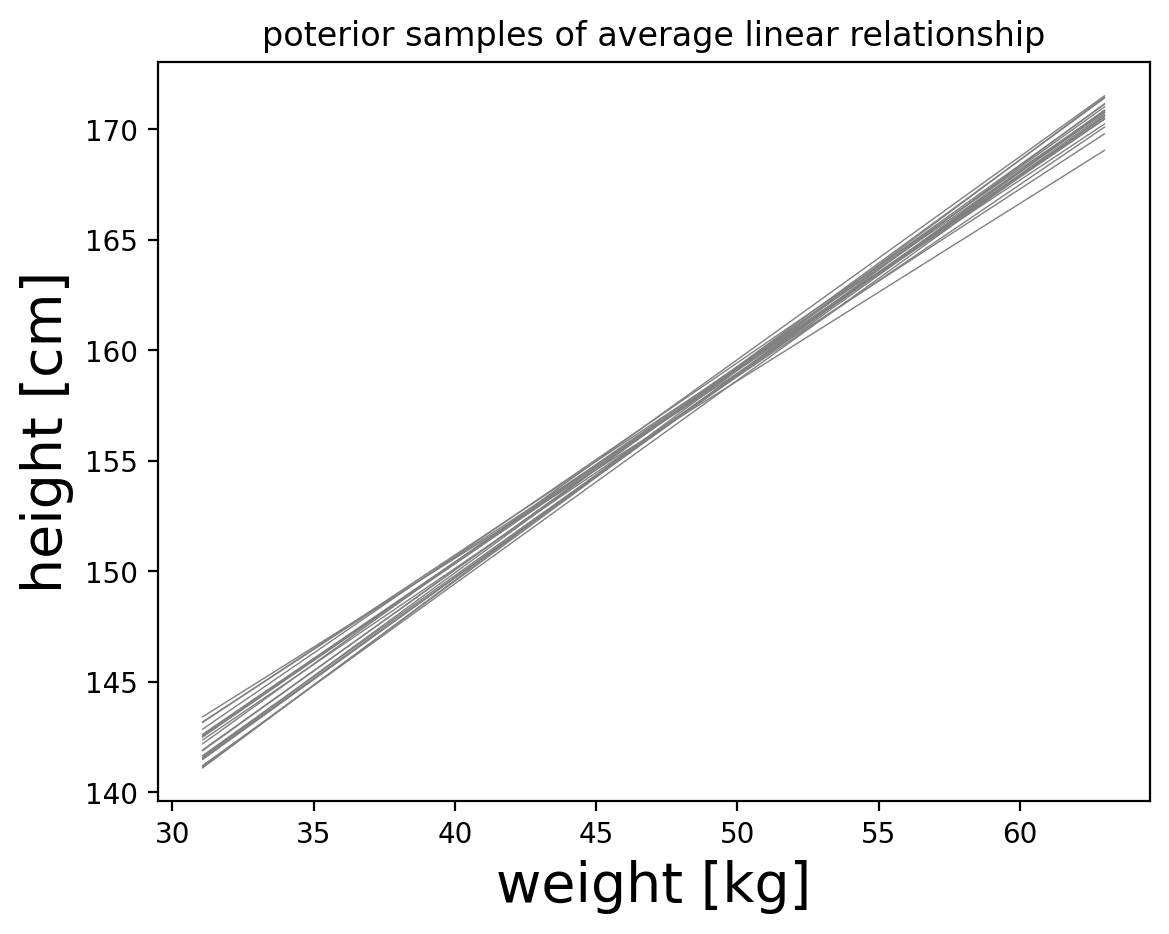

In [20]:
xmin = data_adult['weight'].min()
xmax = data_adult['weight'].max()
xmean = data_adult['weight'].mean()
x = linspace(xmin, xmax, 5) ## weight range
alpha_samples = array(trace_4_3_df['alpha'])[None, ::100] # every 100th data point
logbeta_samples = array(trace_4_3_df['logbeta'])[None, ::100] # every 100th data point
h_avg = alpha_samples + exp(logbeta_samples)*(x[:, None] - xmean)

plot(x, h_avg, '0.5', lw=0.5)
title('poterior samples of average linear relationship')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

## A different way of looking at the posterior distribution for the average height $\mu$

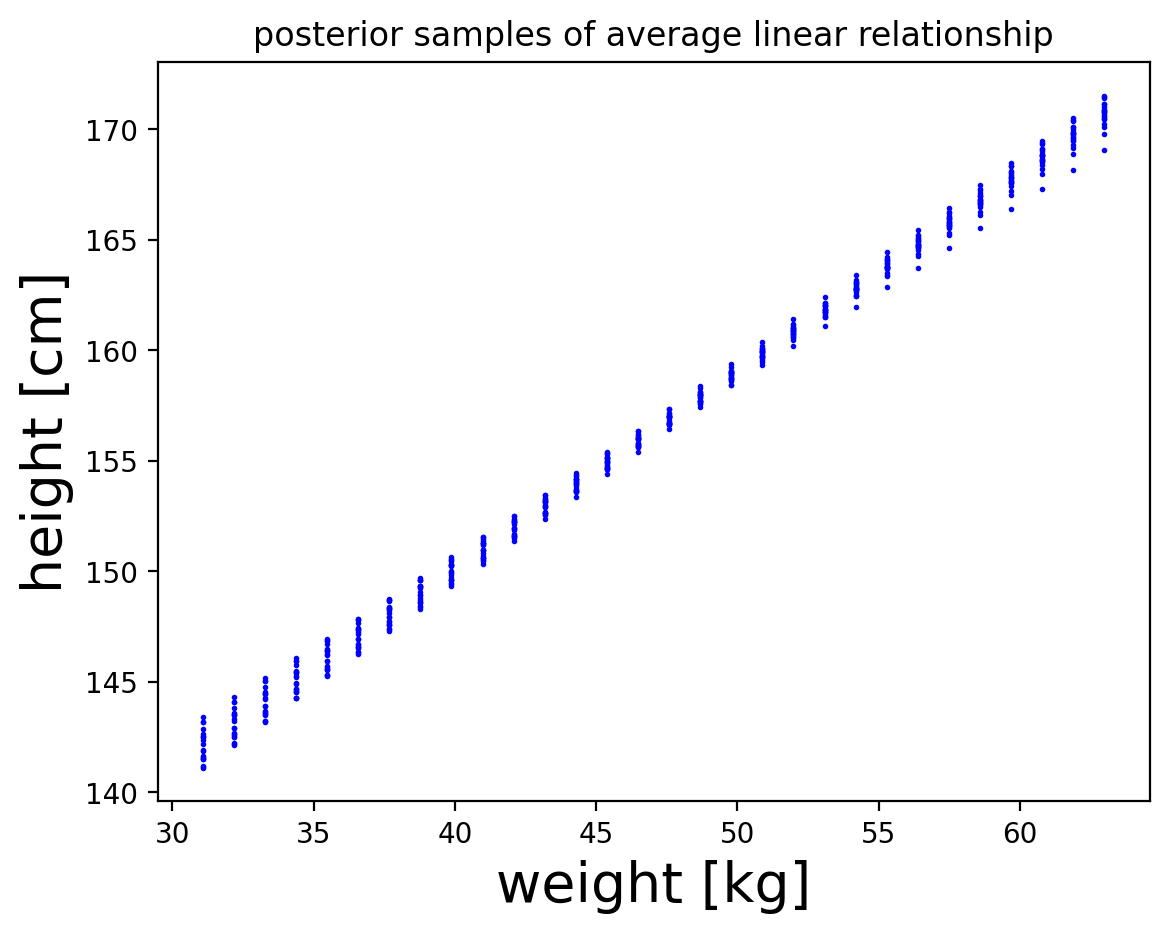

In [21]:
xmin = data_adult['weight'].min()
xmax = data_adult['weight'].max()
xmean = data_adult['weight'].mean()
x = linspace(xmin, xmax, 30) ## weight range
alpha_samples = array(trace_4_3_df['alpha'])[None, ::100] ## every 100th data point
logbeta_samples = array(trace_4_3_df['logbeta'])[None, ::100] ## every 100th data point
mu_samples = alpha_samples + exp(logbeta_samples)*(x[:, None] - xmean)

plot(x, mu_samples, 'b.', ms=2)
title('posterior samples of average linear relationship')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

## Graphing credible intervals of the posterior for average height $\mu$
The shaded region shows the 89% credible intervals of the average height, for each weight

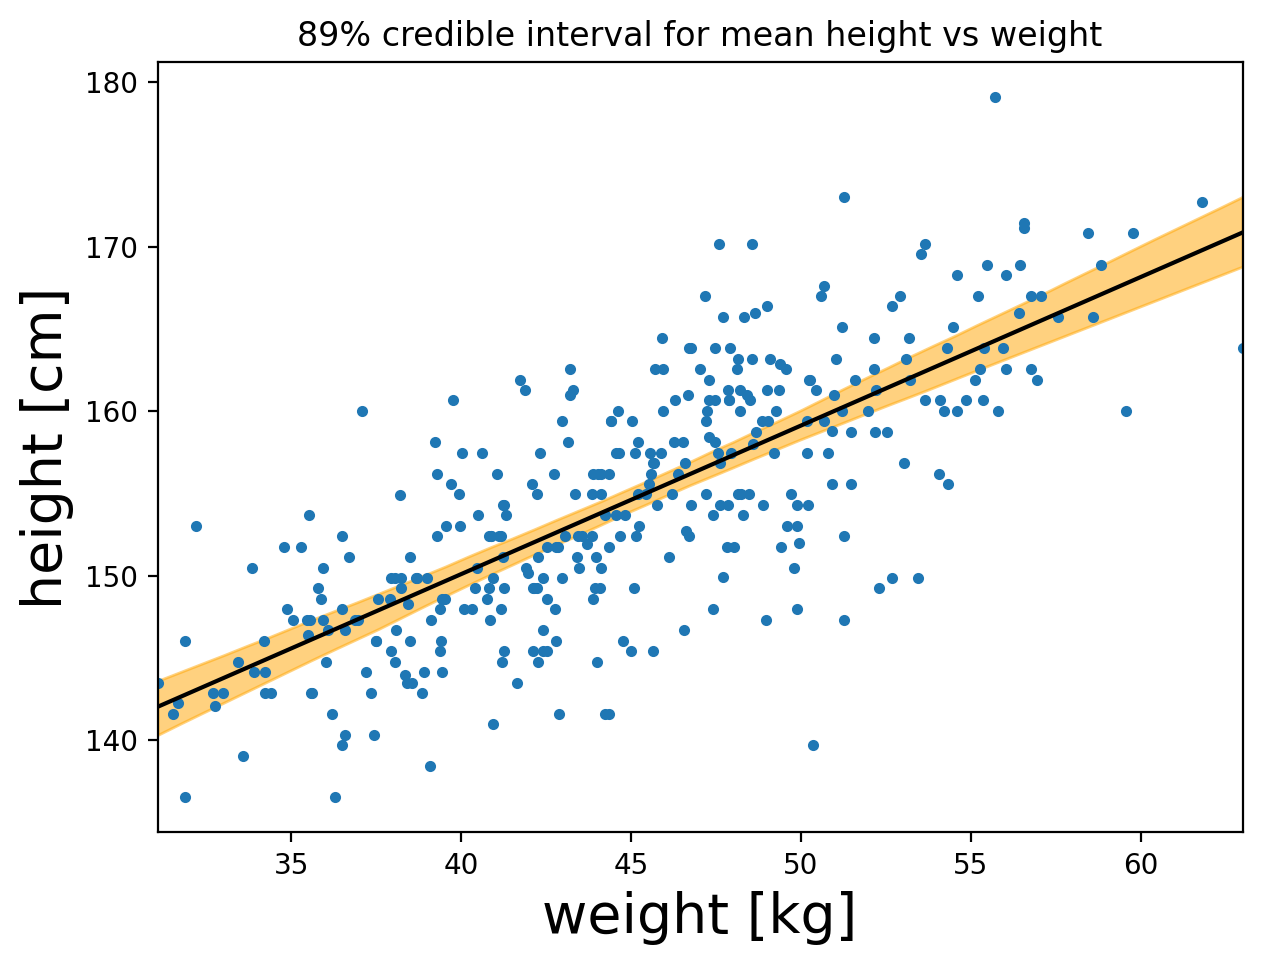

In [23]:
prob = 0.99 ## for credible intervals

xmin = data_adult['weight'].min()
xmax = data_adult['weight'].max()
xmean = data_adult['weight'].mean()
x = linspace(xmin, xmax, 50) ## weight range
alpha_samples = array(trace_4_3_df['alpha'])[None, :]
logbeta_samples = array(trace_4_3_df['logbeta'])[None, :]
N_posterior_samples = alpha_samples.size

## the posterior mean
mu_avg = alpha_samples.mean() + exp(logbeta_samples).mean()*(x - xmean)

mu_samples = alpha_samples + exp(logbeta_samples)*(x[:, None] - xmean)
## lower bound and upper bound for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]



figure(1, [7, 5])
plot(data_adult['weight'], data_adult['height'], '.')
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('89% credible interval for mean height vs weight')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

# Let us add in the prediction intervals
## we want to look at variability in height and average height

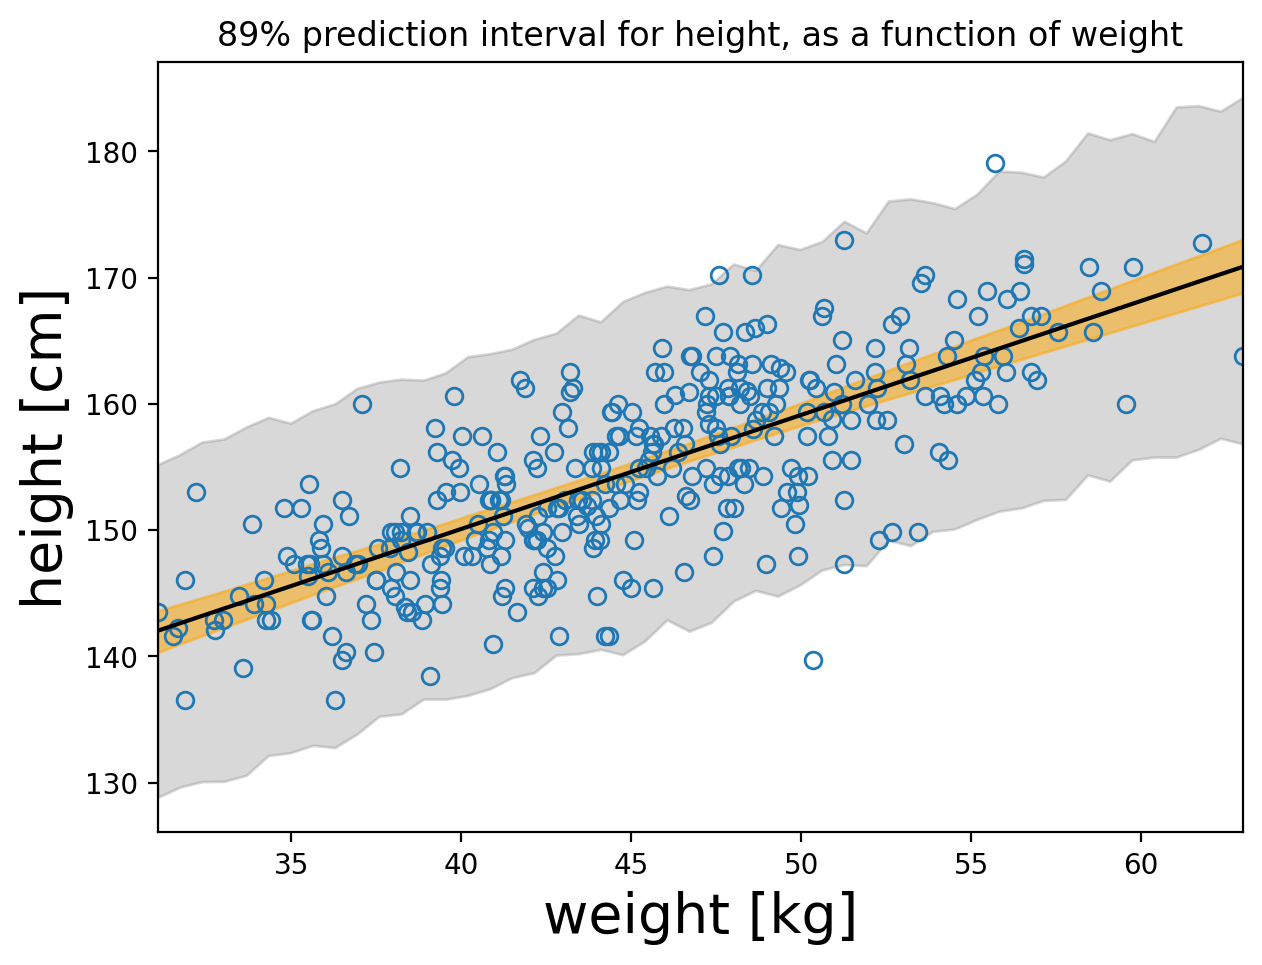

In [25]:
prob = 0.99 ## for credible intervals

xmin = data_adult['weight'].min()
xmax = data_adult['weight'].max()
xmean = data_adult['weight'].mean()

N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(trace_4_3_df['alpha'])[None, :]
logbeta_samples = array(trace_4_3_df['logbeta'])[None, :]
sigma_samples = array(trace_4_3_df['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + exp(logbeta_samples).mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + exp(logbeta_samples)*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_adult['weight'], data_adult['height'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('89% prediction interval for height, as a function of weight')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

# There is no reason we have to use a linear function for regression!
## Let us try fitting a cubic function to the full height vs weight dataset
For stability, we first 'standardize' the predictor variable (weight) so that $x_s$ has mean zero and unit standard deviation,
$$ x_s = \frac{x_{i} - \bar{x}}{\text{std}(x_{i} - \bar{x})} .$$
Our cubic model is
\begin{align*}
    h_{i} &\sim \text{Normal}(\mu_{i}, \sigma) \\
    \mu_{i} &= \alpha + e^{\log(\beta_1)}x_s + \beta_2 x_s^2 + \beta_3 x_s^3 \\
    \alpha &\sim \text{Normal}(178, 20) \\
    \log(\beta_1) & \sim \text{Normal}(0, 1) \\
    \beta_2 & \sim \text{Normal}(0, 1) \\
    \beta_3 & \sim \text{Normal}(0, 1) \\
    \sigma &\sim \text{Uniform}(0, 50)
\end{align*}

In [26]:
x_shifted = array(data_all['weight'] - data_all['weight'].mean())
x_standardized = x_shifted/x_shifted.std()
with pm.Model() as model_cubic:
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    logbeta1 = pm.Normal("logbeta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)
    beta3 = pm.Normal("beta3", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = alpha + exp(logbeta1)*x_standardized + beta2*x_standardized**2 + beta3*x_standardized**3
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data_all['height'])
    trace_cubic = pm.sample(1000, tune=1000) ## these are the MCMC samples!
trace_cubic = trace_cubic.posterior.to_dataframe()
trace_cubic

Output()

Output()

alpha     beta2     beta3  logbeta1     sigma
chain draw                                                    
0     0     146.442747 -6.047988  3.711760  2.718411  4.694896
      1     146.519083 -5.989448  3.702872  2.703793  4.677891
      2     146.234345 -6.033555  4.068898  2.646040  5.035492
      3     146.324290 -5.884395  3.836330  2.713040  4.510215
      4     146.132488 -6.127145  3.614445  2.710131  4.915089
...                ...       ...       ...       ...       ...
1     995   147.141300 -6.450698  3.610923  2.701084  5.163617
      996   146.405328 -6.340735  3.575233  2.697293  4.593391
      997   146.312752 -5.890114  3.512812  2.736830  4.899759
      998   146.323962 -6.395639  3.414301  2.718150  4.734856
      999   146.450996 -6.076217  3.345280  2.754617  4.983049

[2000 rows x 5 columns]

## Check our priors

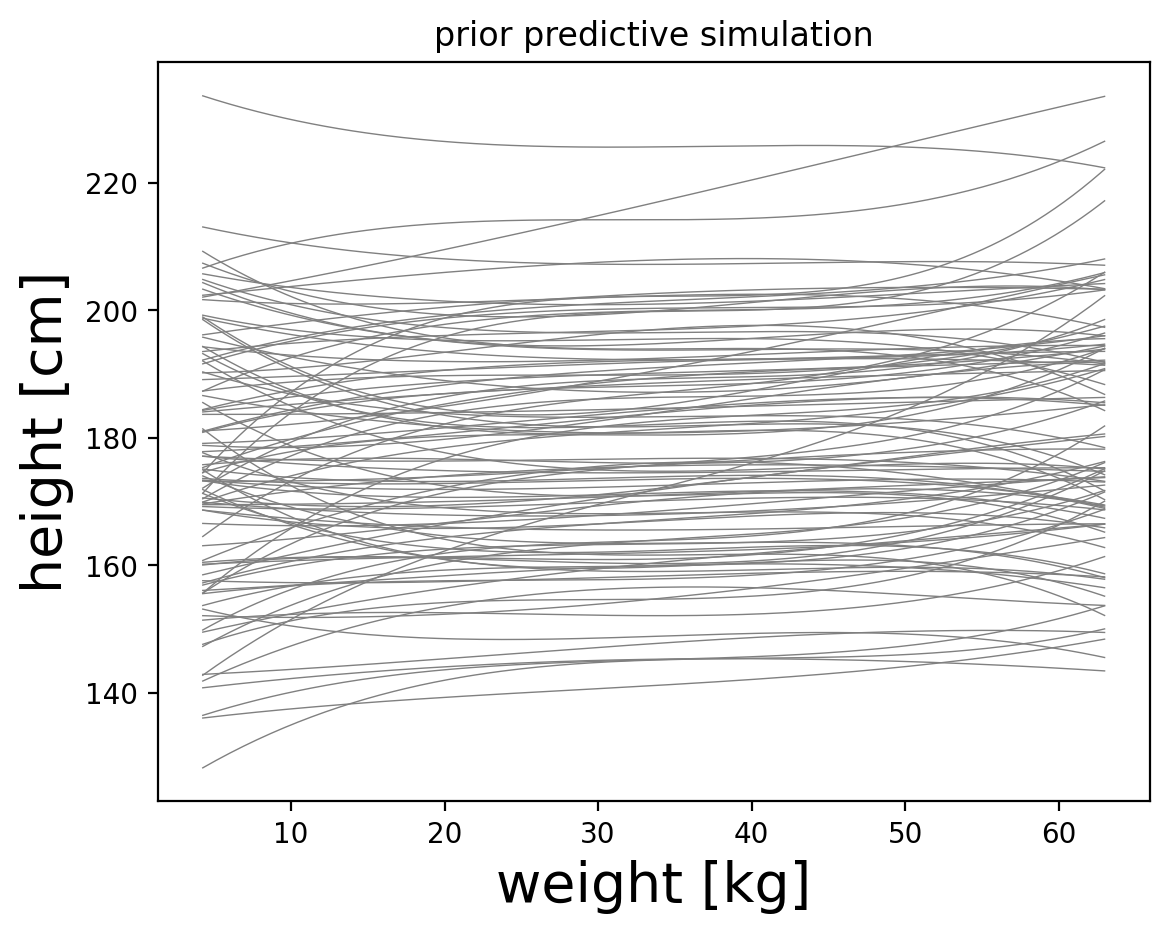

In [27]:
n_samples = 100

alpha = stats.norm.rvs(178, 20, n_samples)
logbeta1 = stats.norm.rvs(0, 1, n_samples)
beta2 = stats.norm.rvs(0, 1, n_samples)
beta3 = stats.norm.rvs(0, 1, n_samples)

xmin = data_all['weight'].min()
xmax = data_all['weight'].max()
xmean = data_all['weight'].mean()
x = linspace(xmin, xmax, 200) ## weight range
xsmin = x_standardized.min()
xsmax = x_standardized.max()
x_s = linspace(xsmin, xsmax, 200) ## standardized weight range

mu = (alpha[None, :]
      + exp(logbeta1[None, :])*x_s[:, None]
      + beta2[None, :]*x_s[:, None]**2
      + beta3[None, :]*x_s[:, None]**3)

plot(x, mu, '0.5', lw=0.5)
# ylim(-100, 400)
title('prior predictive simulation')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

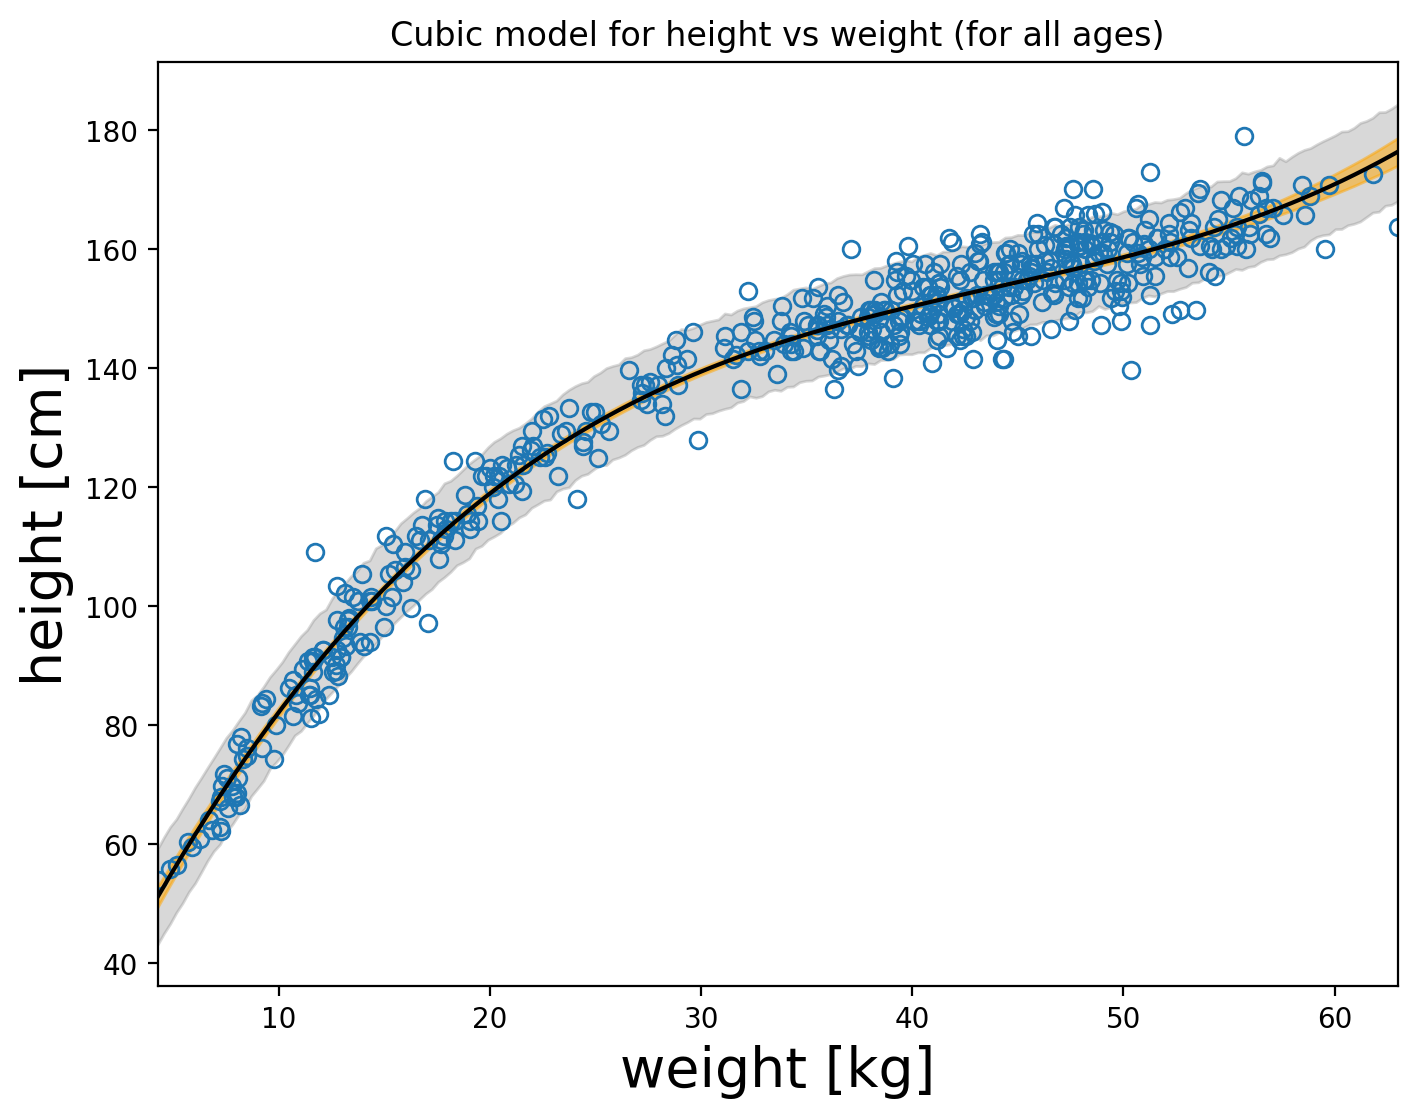

In [28]:
prob = 0.89 ## for credible intervals

N_weight = 200
xmin = data_all['weight'].min()
xmax = data_all['weight'].max()
xmean = data_all['weight'].mean()
x = linspace(xmin, xmax, N_weight) ## weight range
xsmin = x_standardized.min()
xsmax = x_standardized.max()
x_s = linspace(xsmin, xsmax, N_weight)[:, None] ## standardized weight range

alpha_samples = array(trace_cubic['alpha'])[None, :]
logbeta1_samples = array(trace_cubic['logbeta1'])[None, :]
beta2_samples = array(trace_cubic['beta2'])[None, :]
beta3_samples = array(trace_cubic['beta3'])[None, :]
sigma_samples = array(trace_cubic['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = (alpha_samples.mean()
          + exp(logbeta1_samples).mean()*x_s
          + beta2_samples.mean()*x_s**2
          + beta3_samples.mean()*x_s**3)
#### collect samples of the average height
mu_samples = (alpha_samples
              + exp(logbeta1_samples)*x_s
              + beta2_samples*x_s**2
              + beta3_samples*x_s**3)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [8, 6])
plot(data_all['weight'], data_all['height'], 'o', mfc='none')
fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('Cubic model for height vs weight (for all ages)')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);